# **SOLUCIÓN EJERCICIO 3 - EXAMEN Ai Lab School**

Se descarga la base de datos de la Estación Meteorológica del Instituto Max-Planck de Biogeoquímica en Jena, Alemania. 
Se trata de una base de datos en la que 14 valores diferentes fueron registrados cada 10 minutos, a lo largo de varios años. 
En la terminología de las series de tiempo, cada uno de los registros de este tipo de base de datos, se denomina ***timestep***.

In [1]:
# Descargar base de datos
!cd ~/Downloads
!mkdir jena_climate
!cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

/bin/bash: line 0: cd: /root/Downloads: No such file or directory
--2021-08-18 18:42:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.25.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.25.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2021-08-18 18:42:13 (115 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Analicemos los datos:

In [2]:
import os

fname = '/content/jena_climate_2009_2016.csv'  # Ubicamos la DB
f = open(fname)                                # Abrimos el archivo
data = f.read()                                # Leemos el archivo, guardandolo
f.close()                                      # Cerramos el archivo

lines = data.split('\n')                       # Particiona la lista de texto por salto de linea
header = lines[0].split(',')                   # Se toma el nombre de cada columna ya que la primera linea son los encabezados
lines = lines[1:]                              # Las lineas se toman desde el indice uno, teniendo los registros, sin el encabezado

Convertimos las líneas de texto en un numpy array:

In [3]:
# Keras no recibe listas, unicamente numpy arrays o tensores
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))   # Limitando las orillas
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]  # Ir poniendo cada valor en cada fila, ya en punto flotante
    float_data[i, :] = values

# **Normalización de los datos**

In [4]:
# Tener los datos en un rango similar para facilitar el proceso
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# **Construcción de un generador de datos**

Nuestro generador de datos, va a generar la tupla (muestras, etiquetas), donde las muestras representan un lote de registros climáticos, por ejemplo, si el tamaño del lote es de 128, quiere decir que el generador va a producir 128 registros (muestras) climáticos, y ante cada una de las 128 muestras, se tendrá su respectiva etiqueta.<br>
Técnicamente, el generador es una función que toma los siguientes argumentos:<br>
data: The original array of floating point data, 

*   data: Es el arreglo original de los datos, el cual fue normalizado previamente.
*   lookback: Cuántos timesteps del pasado deben considerarse para constituir los datos de entrada.
*   delay: Cuántos timesteps posteriores deben contemplarse para conformar las etiquetas.
*   min_index y max_index: Estos índices permiten delimitar los timesteps que se van a usar. Además, son útiles para realizar la partición de los datos en conjuntos de validación y prueba.
*   shuffle: Permite determinar si las muestras se tomarán en orden cronológico o de forma aleatoria.
*   batch_size:  Número de muestras por lote.
*   step:  El período, en timesteps, en que se realizará el muestro de datos. En este caso, su valor será 3 con la intención de muestrear un dato cada media hora.


In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=3):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)   # Se genera un lote de 128 valores entre 1440-200000
        else:                                                       
            if i + batch_size >= max_index:                          
                i = min_index + lookback                            # Se resetea el valor de i
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),          # samples (128, (1440/6), 14)
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))        # targets (128)
        for j, row in enumerate(rows):                            
            indices = range(rows[j] - lookback, rows[j], step)  # range(1440-1440, 1440, 6) --> range(0, 1440, 6)
            samples[j] = data[indices] 
            targets[j] = data[rows[j] + delay][1]               # data[1440 + 144] 
        yield samples, targets

Ahora, usaremos el generador para construir tres generadores, uno para entrenamiento, otro para validación y el restante para prueba. Cada uno de ellos, se conformará por diferentes segmentos temporales de los datos de entrada: el generador de entrenamiento usará los primeros 200,000 datos, el de validación los siguientes 100,000 y el de prueba empleará los restantes.

In [6]:
lookback = 1440      # Se toma la informacion de 10 dias previos, los cuales consisten en 1440 timestep para predecir el futuro 
step = 3             # Permite hacer un muestreo, para cada valor de entrada (1440 timesteps) se hace el muestro cada 3 timesteps --> 30 minutos 
delay = 144          # Timestep por dia; 144 --> Pronostico Dia 11, 288 --> Pronostico Dia 12, 432 --> Pronostico Dia 13
batch_size = 128     # Lotes para procesar

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# **Arquitectura convolucional recurrente**

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Ai Lab School/EXAMEN/EJERCICIO 3/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=200,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks = [mc])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
200/200 [==============================] - 96s 466ms/step - loss: 0.3134 - val_loss: 0.3112

Epoch 00001: val_loss improved from inf to 0.31118, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/EXAMEN/EJERCICIO 3/best_model.h5
Epoch 2/5
200/200 [==============================] - 94s 469ms/step - loss: 0.2988 - val_loss: 0.2785

Epoch 00002: val_loss improved from 0.31118 to 0.27851, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/EXAMEN/EJERCICIO 3/best_model.h5
Epoch 3/5
200/200 [==============================] - 92s 463ms/step - loss: 0.2963 - val_loss: 0.2956

Epoch 00003: val_loss did not improve from 0.27851
Epoch 4/5
200/200 [==============================] - 93s 466ms/step - loss: 0.2865 - val_loss: 0.2759

Epoch 00004: val_loss improved from 0.27851 to 0.27586, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/EXAMEN/EJERCICIO 3/best_model.h5
Epoch 5/5
200/200 [==============================] - 93s 466ms/s

## **Curvas de precisión y pérdida**

Mejor época (pérdida)  5


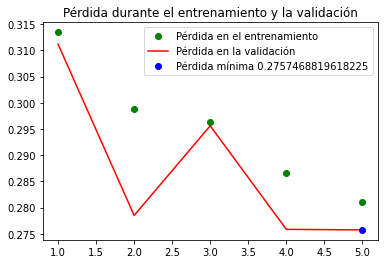

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Pérdida mínima {}'.format(min_val_loss))
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print('Mejor época (pérdida) ', min_val_loss_epoch)

plt.show()